## Building first  Convolution neural network

<pre>-To build this we can use the typical
convolutional block: convolutional layer, activation function, pooling layer. 
Our images are quite small, so we only need one of those.



<pre>We still need to decide how many channels our convolutional layer is going to
produce. In general, the number of channels increases with each convolutional
block. For the sake of simplicity (and later visualization), let’s keep a single channel.

<pre> we are going to use  , kernel size of <mark> three  </mark>
which will <mark><b> reduce the image size by two pixels in each dimension (we are not using padding here)</mark>

In [51]:
#import 
import torch 
import torch.nn as nn
from v1 import StepByStep
from torch.utils.data  import Dataset 
from torchvision import transforms
from torch.utils.data import random_split
from torchvision import transforms
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
import torch.optim  as optim


In [13]:
torch.manual_seed(42)
model_cnn1 = nn.Sequential()

#featurizer 
  # Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channel=1

model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channel, kernel_size=3))
# add activation 
model_cnn1.add_module('Relu1',nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size= 2))

#flattening : n_channels 4  * 4
model_cnn1.add_module('flattern', nn.Flatten())


### model configuration


In [14]:
#classification 
#hidden layer
model_cnn1.add_module('fc1', nn.Linear(in_features= n_channel*4*4, out_features= 10))
#activation
model_cnn1.add_module('relu2' , nn.ReLU())
#output layer 
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

<pre> so you ouput 

In [16]:
#model configuration 
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction = 'mean')
optimizer_cnn1 = optim.SGD(params= model_cnn1.parameters(), lr = lr)

<mark> fasd

In [52]:


#index splitter 
def index_splitter(n, splits, seed= 13):
    idx= torch.arange(n)

    splits_tensor= torch.as_tensor(splits)

    multiplier = n/ splits_tensor.sum()

    splits_tensor= (multiplier  * splits_tensor).long()
    diff= n-splits_tensor.sum()

    splits_tensor[0]= splits_tensor[0]+ diff

    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)



def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler


In [53]:
images, labels = generate_dataset(
img_size=10, n_images=1000, binary=False, seed=17)

In [54]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]
        if self.transform:
            x = self.transform(x)
        return x, self.y[index]

    def __len__(self):
        return len(self.x)


In [55]:
from torchvision.transforms import Compose
from torchvision.transforms import Normalize

In [56]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]



x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(
    x_train_tensor, y_train_tensor,
    transform=train_composer
)
val_dataset = TransformedTensorDataset(
    x_val_tensor, y_val_tensor,
    transform=val_composer
)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(
    dataset=train_dataset, batch_size=16,
    sampler=sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)


In [57]:

sbs_cnn1 = StepByStep(model=model_cnn1, loss_fn= multi_loss_fn , optimizer= optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader= train_loader , val_loader=val_loader )


In [58]:
sbs_cnn1.train(20)

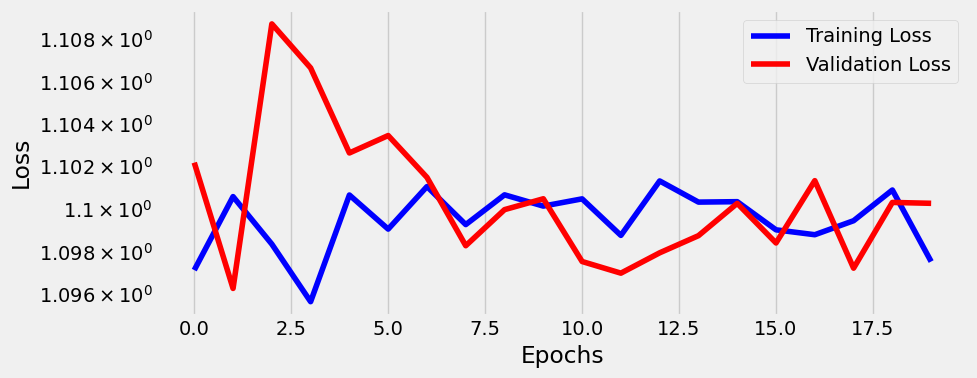

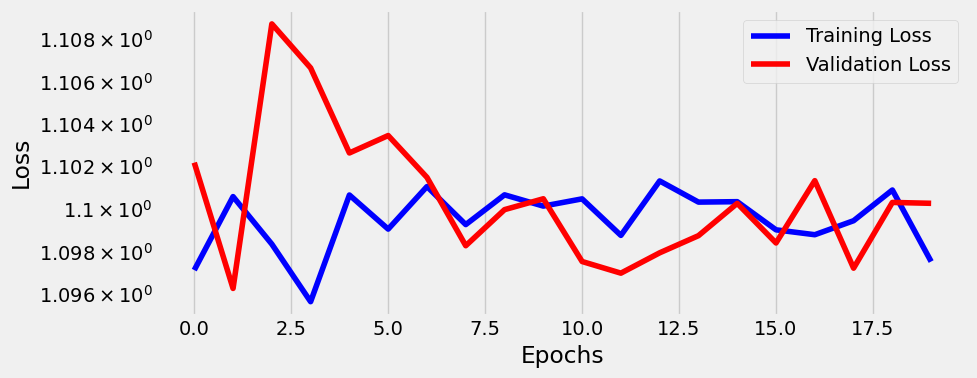

In [59]:
sbs_cnn1.plot_losses()